<img src="../images/logo_VORTEX.png" width="200" height="auto" alt="Company Logo">

| Project| Authors           | Company                                 | Year | Chapter |
|--------|-------------------|-----------------------------------------|------|---------|
| Pywind | Oriol L           | [Vortex FdC](https://www.vortexfdc.com) | 2025 | 4       |

# Chapter 5: Measure Correlate Predict

_Overview_

In this chapter, we will generate and compare three Measure Correlate Predict (MCP) methods:
- Linear MCP.
- Linear MCP categorized by wind sectors.
- Vortex's remodeling.

_Specifically, we will:_

- Generate the MCP.
- Generate the wind direction categorized MCP.
- Load remodeling from Vortex.
- Visualize the histograms and comparisons.
- Compare the statistics of all methods.




_What you'll learn_

You will learn how a classic MCP is performed, alowwing for a categorized method using wind direction. This method can be tunned to categorize other variables like wind speed and even combine categorizations for a more sophisticated method. 

You will learn how MCP affect the wind statistics and also view and evaluate the impact of methods in the wind distribution.

### Import Libraries

In [5]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../examples'))
from example_2_read_txt_functions import *
from example_3_merge_functions import *
from example_4_basic_plots_functions import *

from scipy.stats import wasserstein_distance
import os
from example_5_MeasureCorrelatePredict_functions import plot_histogram_comparison_lines


###  Define Paths and Site & Load data

In [6]:
SITE = 'froya'
pwd = os.getcwd()
base_path = str(os.path.join(pwd, '../data'))

vortex_txt = os.path.join(base_path, f'{SITE}/vortex/SERIE/vortex.serie.era5.utc0.100m.txt')
measurements_txt = os.path.join(base_path, f'{SITE}/measurements/obs.txt')



###  Repeat the process in chapter 3 to read netcdf and merge datasets

We repeat the precess from previous chapter. You can anyway alter this to load and analyse other variables. Or you can subset the datasets for certain episodes, periods or even variable conditioning. We'll work on this anyway in following chapters.

In [7]:
# Read Text Series
ds_vortex_txt = read_vortex_serie(vortex_txt)
df_obs_txt = read_vortex_obs_to_dataframe(measurements_txt)[['M', 'Dir']]
ds_obs_txt = convert_to_xarray(df_obs_txt)[['M', 'Dir']]
#ds_vortex_nc = ds_vortex_nc.rename_vars({'D': 'Dir'})
ds_vortex_txt = ds_vortex_txt[['M', 'Dir']].squeeze().reset_coords(drop=True)
# convert ds_obs_txt to hourly
ds_obs_txt = ds_obs_txt.resample(time='1H').mean()
# =============================================================================
# 3. Convert all to DataFrame, Rename and Merge
# =============================================================================
df_obs_txt = ds_obs_txt.to_dataframe()
df_vortex_txt = ds_vortex_txt.to_dataframe()

df_obs_txt.columns = ['M_obs_txt', 'Dir_obs_txt']
df_vortex_txt.columns = ['M_vortex_txt', 'Dir_vortex_txt']

df_concurrent = df_obs_txt.merge(df_vortex_txt, left_index=True, right_index=True).dropna()
df_all = df_obs_txt.merge(df_vortex_txt, left_index=True, right_index=True, how='outer')

# SAVED DATASETS, CONCURRENT AND ALL PERIODS
#print(df_concurrent.describe())
#print(df_all.describe())



/home/oriol/vortex/git/pywind/notebooks/../examples/example_2_read_txt_functions.py:198: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df: pd.DataFrame = pd.read_csv(infile, **readcsv_kwargs)
/home/oriol/vortex/git/pywind/notebooks/../examples/example_2_read_txt_functions.py:198: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df: pd.DataFrame = pd.read_csv(infile, **readcsv_kwargs)
/home/oriol/miniconda3/envs/python-def/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


## XY Correlation & MCP calculation



Regression Statistics:
Slope: 0.9762
Intercept: 0.2594
R-squared: 0.8676
p-value: 0.0000e+00
Standard Error: 0.0022


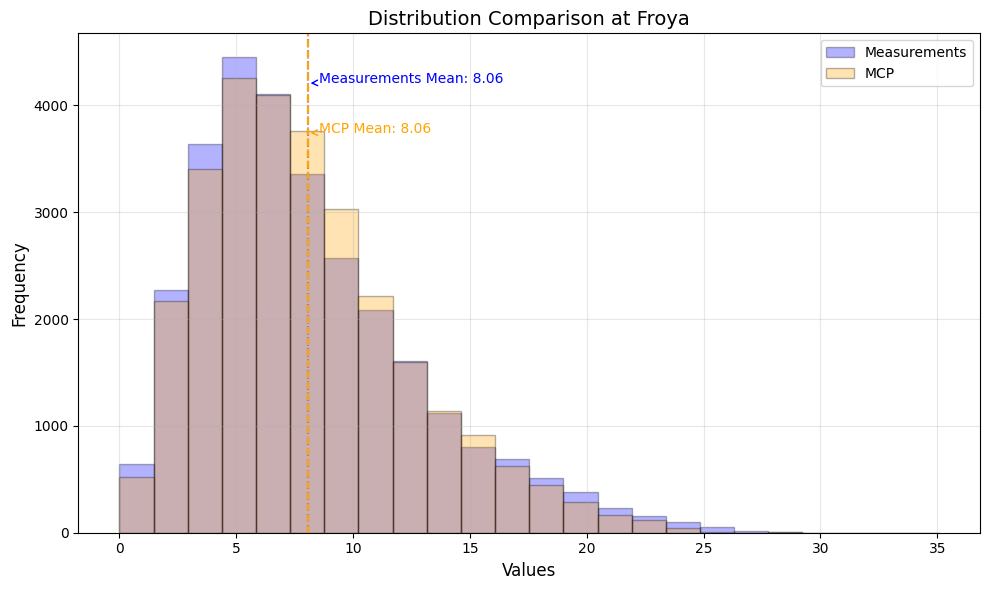

In [ ]:
output_dir = "output"
# Use the functions to compute metrics
xy_stats = plot_xy_comparison(
    df=df_concurrent, 
    x_col='M_vortex_txt', 
    y_col='M_obs_txt',
    x_label='Measurement Wind Speed (m/s)',
    y_label='Vortex Wind Speed (m/s)',
    site=SITE,
    output_dir=output_dir,
    outlyer_threshold=4,
    show=False
)

# Print regression statistics
print(f"\nRegression Statistics:")
print(f"Slope: {xy_stats['slope']:.4f}")
print(f"Intercept: {xy_stats['intercept']:.4f}")
print(f"R-squared: {xy_stats['r_squared']:.4f}")
print(f"p-value: {xy_stats['p_value']:.4e}")
print(f"Standard Error: {xy_stats['std_err']:.4f}")

# =============================================================================
# 5. Compute the MCP
# =============================================================================

## create a new column with the MCP
## Ymcp ) = {xy_stats['intercept'] + {xy_stats['slope']*df_all['M_vortex_txt']}
df_all['Ymcp'] = xy_stats['intercept'] + xy_stats['slope']*df_all['M_vortex_txt']

# concurrent stats

#print(df_all.dropna().describe())

hist_stats = plot_histogram_comparison(
    df=df_all.dropna(),
    cols=['M_obs_txt', 'Ymcp'],
    labels=['Measurements', 'MCP'],
    colors=['blue',  'orange'],
    site=SITE,
    output_dir=output_dir,
    bins=25,
    alpha=0.3
)



## Wind sector categorization MCP




Sector 0-45 Regression Statistics:
Slope: 0.8964, Intercept: 0.4709, R-squared: 0.8222

Sector 45-90 Regression Statistics:
Slope: 0.8884, Intercept: 0.6361, R-squared: 0.7740

Sector 90-135 Regression Statistics:
Slope: 0.8993, Intercept: 0.5758, R-squared: 0.8257

Sector 135-180 Regression Statistics:
Slope: 0.8004, Intercept: 0.7897, R-squared: 0.6757

Sector 180-225 Regression Statistics:
Slope: 1.0177, Intercept: -0.1217, R-squared: 0.8551

Sector 225-270 Regression Statistics:
Slope: 0.9851, Intercept: 0.6212, R-squared: 0.9014

Sector 270-315 Regression Statistics:
Slope: 0.9428, Intercept: 0.9844, R-squared: 0.8918

Sector 315-360 Regression Statistics:
Slope: 0.9806, Intercept: 0.5317, R-squared: 0.8104


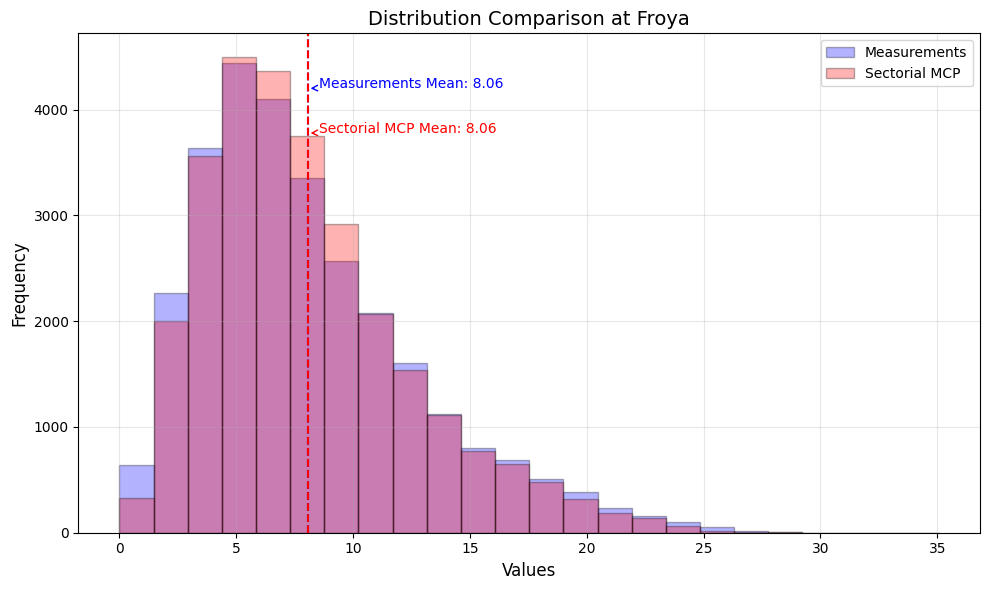

In [ ]:
# Define 8 directional sectors (0-45, 45-90, etc.)
sector_bounds = list(range(0, 361, 45))
sector_labels = [f"{sector_bounds[i]}-{sector_bounds[i+1]}" for i in range(len(sector_bounds)-1)]

# Add a column for the wind direction sector
df_concurrent['dir_sector'] = pd.cut(df_concurrent['Dir_vortex_txt'], 
                                    bins=sector_bounds,
                                    labels=sector_labels,
                                    include_lowest=True,
                                    right=False)
df_all['dir_sector'] = pd.cut(df_all['Dir_vortex_txt'], 
                             bins=sector_bounds,
                             labels=sector_labels,
                             include_lowest=True,
                             right=False)

# Initialize results dictionary to store regression parameters
sector_regressions = {}

# Perform regression for each sector
for sector in sector_labels:
    sector_data = df_concurrent[df_concurrent['dir_sector'] == sector]
    
    # Skip sectors with too few data points
    if len(sector_data) < 5:
        print(f"Warning: Sector {sector} has insufficient data points. Using global regression.")
        sector_regressions[sector] = {'slope': xy_stats['slope'], 'intercept': xy_stats['intercept']}
        continue
    
    # Perform linear regression for this sector
    x = sector_data['M_vortex_txt']
    y = sector_data['M_obs_txt']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    sector_regressions[sector] = {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err
    }
    
    print(f"\nSector {sector} Regression Statistics:")
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_value**2:.4f}")

# Apply sector-specific regression to create the new MCP column
df_all['Ymcp_sectorial'] = None


for sector in sector_labels:
    mask = df_all['dir_sector'] == sector
    if mask.any():  # Only proceed if there's data in this sector
        slope = sector_regressions[sector]['slope']
        intercept = sector_regressions[sector]['intercept']
        df_all.loc[mask, 'Ymcp_sectorial'] = intercept + slope * df_all.loc[mask, 'M_vortex_txt']
    else:
        print(f"Warning: Sector {sector} has no data points. Skipping.")

# Convert Ymcp_sectorial column to float64
df_all['Ymcp_sectorial'] = df_all['Ymcp_sectorial'].astype('float64')
df = df_all.copy().dropna()[['M_obs_txt', 'M_vortex_txt','Ymcp', 'Ymcp_sectorial']]

# Create histogram
hist_stats = plot_histogram_comparison(
    df=df,
    cols=['M_obs_txt',  'Ymcp_sectorial'],
    labels=['Measurements', 'Sectorial MCP'],
    colors=['blue', 'red'],
    site=SITE,
    output_dir=output_dir,
    bins=25,
    alpha=0.3
)




### Vortex remodeling method
The plot function returns statistcs from the regression.

/home/oriol/vortex/git/pywind/notebooks/../examples/example_2_read_txt_functions.py:198: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df: pd.DataFrame = pd.read_csv(infile, **readcsv_kwargs)


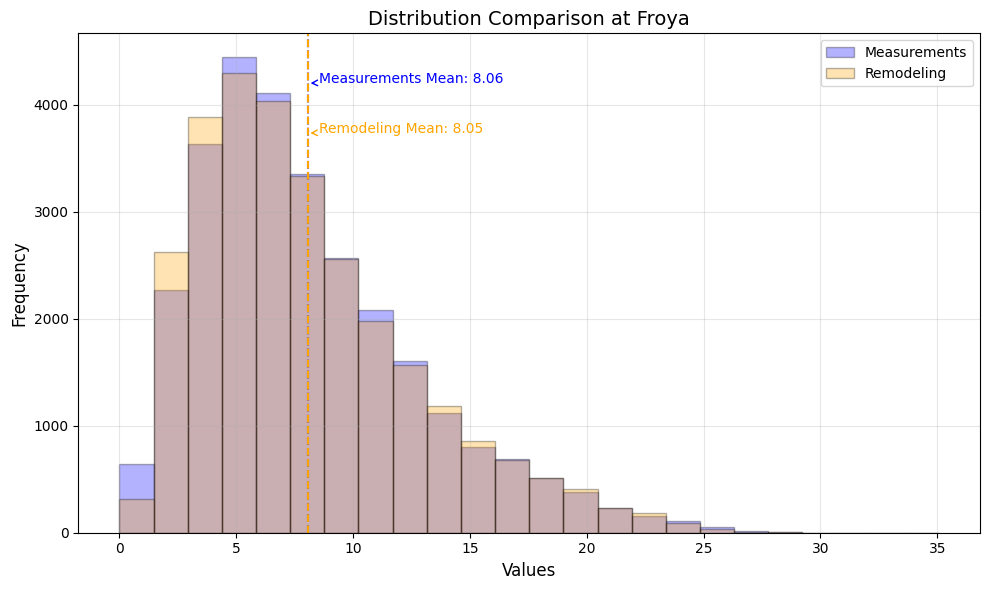

In [10]:
# we now introduce a different method, Vortex Remodeling

file_remodeling_txt =  os.path.join(base_path, f'{SITE}/vortex/SERIE/vortex.remodeled.719711.20y 100m UTC+00.0 ERA5 - PUBfull_100.txt')
ds_remodeling_txt = read_remodeling_serie(file_remodeling_txt)
df_remodeling_txt = ds_remodeling_txt.to_dataframe().rename(columns={'M': 'M_remodeling_txt'})
df =df.merge(df_remodeling_txt[['M_remodeling_txt']], left_index=True, right_index=True, how='outer').dropna()

hist_stats = plot_histogram_comparison(
    df=df,
    cols=['M_obs_txt', 'M_remodeling_txt'],
    labels=['Measurements', 'Remodeling'],
    colors=['blue',  'orange'],
    site=SITE,
    output_dir=output_dir,
    bins=25,
    alpha=0.3
)


## Statistics comparison



In [11]:

# =============================================================================
# 8. Compare statsistics
# =============================================================================
# Import required library for Earth Mover's Distance calculation

# Calculate Earth Mover's Distance (Wasserstein distance) for each method

emd_results = {}
for col in ['Ymcp', 'Ymcp_sectorial', 'M_remodeling_txt']:
    # Calculate EMD between the method and observations
    emd = wasserstein_distance(df['M_obs_txt'], df[col])
    emd_results[col] = emd




# Calculate mean absolute error and root mean squared error for each prediction method compared to observations
print("\nError Metrics (compared to M_obs_txt):")
print("=" * 80)
for col in ['Ymcp', 'Ymcp_sectorial', 'M_remodeling_txt']:
    mae = (df[col] - df['M_obs_txt']).abs().mean()
    rmse = ((df[col] - df['M_obs_txt']) ** 2).mean() ** 0.5
    bias = (df[col] - df['M_obs_txt']).mean()
    print(f"{col}:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f} m/s")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f} m/s")
    print(f"  Bias: {bias:.4f} m/s")
    print(f"  Histogram error(EMD): {emd_results[col]:.4f}")





Error Metrics (compared to M_obs_txt):
Ymcp:
  Mean Absolute Error (MAE): 1.2910 m/s
  Root Mean Squared Error (RMSE): 1.7199 m/s
  Bias: 0.0002 m/s
  Histogram error(EMD): 0.2692
Ymcp_sectorial:
  Mean Absolute Error (MAE): 1.2345 m/s
  Root Mean Squared Error (RMSE): 1.6612 m/s
  Bias: 0.0000 m/s
  Histogram error(EMD): 0.2569
M_remodeling_txt:
  Mean Absolute Error (MAE): 1.0901 m/s
  Root Mean Squared Error (RMSE): 1.4832 m/s
  Bias: -0.0092 m/s
  Histogram error(EMD): 0.0694


## Visual comparison: histogram



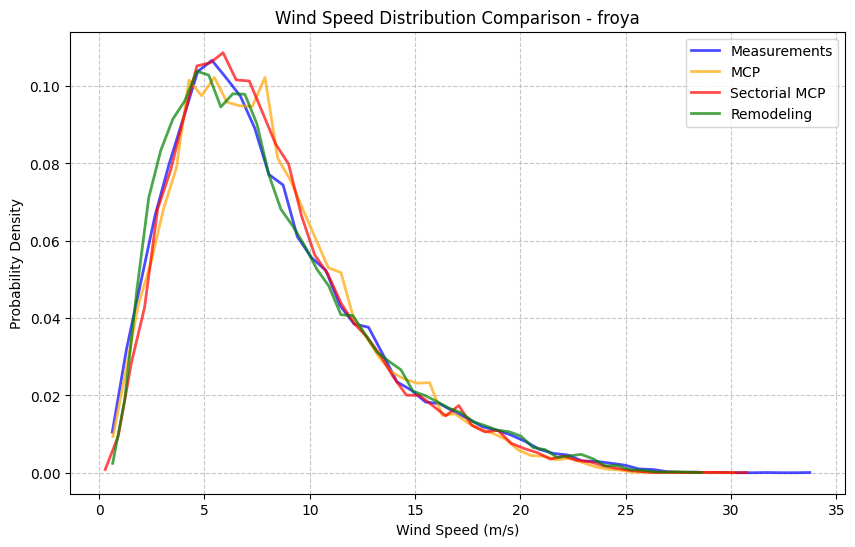

Histogram line plot saved to output/histogram_comparison_froya.png


In [12]:
# =============================================================================
# 9. Linear histogram for histogram comparison
# =============================================================================


# Example usage for the new function
hist_line_stats = plot_histogram_comparison_lines(
    df=df,
    cols=['M_obs_txt', 'Ymcp', 'Ymcp_sectorial', 'M_remodeling_txt'],
    labels=['Measurements', 'MCP', 'Sectorial MCP', 'Remodeling'],
    colors=['blue', 'orange', 'red', 'green'],
    site=SITE,
    output_dir=output_dir,
    bins=50
)


### Thank you for completing this Notebook! 
### *Other references available upon request.*

Remember, you can tune up to:

- Check for the simple method.
- Change the variables in categorization for MCP calculation.
- Combine different categorizations.
- Explore in and out of training variations.


**Don't hesitate to [contact us](https://vortexfdc.com/contact/) for any questions and information.**

## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description                         |
|-------------------|---------|------------|--------------------------------------------|
| 2025-05-16        | 0.1     | Oriol L    | Notebook creation                          |

<hr>

## <h3 align="center"> © Vortex F.d.C. 2025. All rights reserved. <h3/>